### 골밀도 & 체지방 Linear Modeling and prediction
사용 데이터 : 국민건강영양조사 기본DB + 골밀도/체지방검사DB    
기간 : 2008 ~ 2010

### 1. 국건영 최종DB 생성하기 - 건보공단 변수랑 같은 변수만 남긴 DB

In [1]:
# 기본
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import font_manager, rc
import platform
from tqdm import tqdm
import sklearn
from sklearn import linear_model
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# crawling
import requests
import lxml.html
import sqlite3
from pandas.io import sql
from bs4 import BeautifulSoup

# 한글 폰트 설정
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

#### 골밀도+체지방검사 dataset 전처리
    1. 2008-2010 통합
    2. 필요한 변수 9개 (10.06 10개로 수정)만 뽑아서 저장

In [39]:
# fourth = pd.read_csv('골밀도및체지방검사_4기(2008-2009).csv', encoding = 'euc-kr')
# fourth.drop(['Unnamed: 0'], axis = 1, inplace = True)
# fourth

# fifth = pd.read_csv('골밀도및체지방검사_5기 (2010-2011).csv', encoding = 'euc-kr', low_memory = False)
# fifth.drop(['Unnamed: 0'], axis = 1, inplace = True)
# fifth

# fourth08 = fourth.loc[fourth['year'] == 2008].reset_index(drop= True)
# fourth08

# fourth09 = fourth.loc[fourth['year'] == 2009].reset_index(drop = True)
# fourth09

# fifth10 = fifth.loc[fifth['year'] == 2010].reset_index(drop = True)
# fifth10

# fifth11 = fifth.loc[fifth['year'] == 2011].reset_index(drop = True)
# fifth11

# bone_density_body_fat = pd.concat([fourth08, fourth09, fifth10, fifth11], axis = 0).reset_index(drop = True)
# bone_density_body_fat

# bone_density_body_fat.to_csv('골밀도및체지방검사 (2008-2011).csv', encoding = 'euc-kr', index = False)

#### 최종 골밀도 데이터 다시 불러오기

In [2]:
bone_density_body_fat = pd.read_csv('골밀도및체지방검사 (2008-2011).csv', encoding = 'euc-kr', low_memory = False)

bone_density_body_fat

,mod_d,ID,year,region,town_t,apt_t,psu,sex,age,incm,...,kstrata2,age_month,wt_dw,DXW_ex,ID_fam,DX1_dg,DX1_pt,DX2_dg,DX2_1,DX2_1_1
0,b'2019.03.06.',b'A448440901',2008.0,1.0,1.0,1.0,b'A448',1.0,70.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'2019.03.06.',b'A448440902',2008.0,1.0,1.0,1.0,b'A448',2.0,68.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'2019.03.06.',b'A448680102',2008.0,1.0,1.0,1.0,b'A448',2.0,48.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'2019.03.06.',b'A448680501',2008.0,1.0,1.0,1.0,b'A448',2.0,35.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'2019.03.06.',b'A448740903',2008.0,1.0,1.0,1.0,b'A448',2.0,70.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,b'2019.03.06.',b'O359840901',2011.0,15.0,1.0,1.0,b'O359',2.0,60.0,1.0,...,NaN,NaN,NaN,3.0,b'O3598409',2.0,8.0,2.0,8888.0,NaN
21299,b'2019.03.06.',b'O359859801',2011.0,15.0,1.0,1.0,b'O359',1.0,68.0,1.0,...,NaN,NaN,NaN,3.0,b'O3598598',2.0,8.0,2.0,8888.0,NaN
21300,b'2019.03.06.',b'O359859802',2011.0,15.0,1.0,1.0,b'O359',2.0,61.0,1.0,...,NaN,NaN,NaN,3.0,b'O3598598',2.0,8.0,2.0,8888.0,NaN
21301,b'2019.03.06.',b'O359920901',2011.0,15.0,1.0,1.0,b'O359',1.0,65.0,1.0,...,NaN,NaN,NaN,3.0,b'O3599209',2.0,8.0,2.0,8888.0,NaN


In [3]:
# 필요한 변수 9개만 뽑기 + 10.01 가중치까지 추가 + 10.6 총골량 추가

# DW_SBT_BMD : 총 골밀도 (머리제외)
# DW_WBT_BMD : 총 골밀도
# DW_Trk_FT : 몸통(trunk) 지방량
# DW_Trk_MS : 몸통(trunk) 무게
# DW_SBT_FT : 총지방량 (머리제외)
# DW_WBT_FT : 총(whole body total) 지방량 
# DX_F_Ts_A : 대퇴골 전체의 T-score (아시아 기준)
# DX_S_Ts_A : 요추의 T-score (아시아 기준)
# DX_FN_Ts_A : 대퇴골 경부의 T-score (아시아 기준)

# wt_ex : 2008-2009 검진조사 가중치
# wt_itvex : 2010 - 2011 검진조사 가중치


bone_data = bone_density_body_fat[['ID', 'year', 'DW_WBT_BMC', 'DW_SBT_BMD', 'DW_WBT_BMD', 'DW_Trk_FT', 'DW_Trk_MS', 'DW_SBT_FT', 'DW_WBT_FT', 'DX_F_Ts_A', 'DX_S_Ts_A', 'DX_FN_Ts_A', 'wt_ex', 'wt_itvex']].copy()
bone_data

,ID,year,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A,wt_ex,wt_itvex
0,b'A448440901',2008.0,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823,2864.202488,3921.572322
1,b'A448440902',2008.0,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729,3394.490707,3547.542445
2,b'A448680102',2008.0,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346,14156.736799,13850.745707
3,b'A448680501',2008.0,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561,4661.385099,4974.748045
4,b'A448740903',2008.0,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364,7724.920372,11619.345735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,b'O359840901',2011.0,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738,NaN,2947.596354
21299,b'O359859801',2011.0,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065,NaN,4529.308822
21300,b'O359859802',2011.0,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065,NaN,2947.596354
21301,b'O359920901',2011.0,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887,NaN,4529.308822


---------------------------------------

#### 기본DB dataset 전처리
    1. 2008-2010 통합
    2. 필요한 변수 (건보공단이랑 일치하는 변수)만 뽑아서 저장

#### 건보공단이랑 일치하는 변수 list

- year : 조사연도
- ID : 개인 아이디
- psu : 조사구번호
- HE_ht : 신장
- HE_wt : 체중        


- HE_BMI : 체질량지수
- HE_sbp_tr : 최종 수축기 혈압(보정값)
- HE_dbp_tr : 최종 이완기 혈압(보정값)
- HE_obe : 비만유병여부(19세이상) - categorical
- HE_Upro : 요단백  - categorical
- HE_HbA1c : 당화혈색소
- HE_glu : 공복혈당
- HE_chol : 총콜레스테롤
- HE_ast : GOT
- HE_alt : GPT
- HE_tb : 흉부영상 판독결과  - categorical
- HE_HP_tr : 고혈압 유병여부(30세이상, 보정값) - categorical
- DI3_lt : 뇌졸중 평생유병여부 - categorical
- DI4_lt : 심근경색증 또는 협심증 평생유병여부 - categorical
- HE_DM : 당뇨병유병여부(19세이상) - categorical
- HE_wc : 허리둘레
- HE_HDL_st2 : 전환식 HDL-콜레스테롤
- HE_LDL_drct : LDL콜레스테롤_직접검사
- HE_crea : 혈중크레아티닌
- D_1_1 : 주관적 건강상태 - categorical       


- L_BR1 : 조사 1일전 아침식사 섭취여부 - categorical
- L_LN1 : 조사 1일전 점심식사 섭취여부 - categorical
- L_DN1 : 조사 1일전 저녁식사 섭취여부 - categorical
--> 이거 세개를 하나로 축소해야 함 (건보공단 변수는 하나임)


- N_NA : 1일 나트륨 섭취량(mg)     


- F_BEEF : 쇠고기 (국, 탕, 찌개, 편육, 장조림, 구이,볶음, 비프까스, 튀김, 찜 포함) - categorical
- F_CHICK : 닭고기 (삼계탕, 백숙, 찜, 튀김, 조림, 볶음 포함) - categorical
- F_PORK : 돼지고기 (찌개, 구이, 볶음, 돈까스, 튀김 포함) - categorical
- --> 이거 세개를 하나로 축소해야 함 (건보공단 변수는 하나임)     


- BS3_1 : (성인) 현재흡연 여부 - categorical
- BS3_2 : (성인) 현재흡연자 하루 평균 흡연량 - numerical 이나, 888 / 999 로 처리된 거 0으로 전처리 해줘야 함    


- BD1_11 : (만12세이상) 1년간 음주빈도 - categorical
- BD2_1 : (만12세이상) 한번에 마시는 음주량 - categorical     


- BE3_21 : 1주일간 중등도 신체활동 일수 - categorical
- BE3_22 : 중등도 신체활동 지속시간(시간) - numerical 이나, 88 / 99 로 처리된 거 0으로 전처리 해줘야 함     


- BP1 : 평소 스트레스 인지 정도 - categorical    


- DI3_dg : 뇌졸중 의사진단여부 - categorical
- DI4_dg : 심근경색증 또는 협심증 의사진단여부 - categorical
- DI1_dg : 고혈압 의사진단여부 - categorical
- DE1_dg : 당뇨병 의사진단여부 (소아청소년 포함) - categorical
- DI2_dg : 고지혈증 의사진단여부 - categorical   


- DI3_pt : 뇌졸중 치료 - categorical
- DI4_pt : 심근경색증 또는 협심증 치료 - categorical
- DI1_pt : 고혈압 치료 - categorical
- DE1_pt : 당뇨병 치료 - categorical  
- DI2_pt : 고지혈증  치료 - categorical      


- HE_hepaB : B형간염표면항원 양성여부(10세이상) - categorical
- BS6_2_2 : (성인) 과거흡연자 흡연 기간(월) - numerical 이나, 88 / 99 로 처리된 거 0으로 전처리 해줘야 함
- BS6_3 : (성인) 과거흡연자 하루 평균 흡연량 - numerical 이나, 88 / 99 로 처리된 거 0으로 전처리 해줘야 함
- BS2_1 : (성인) 흡연 시작연령 - numerical 이나, 88 / 99 로 처리된 거 0으로 전처리 해줘야 함     


- pa_high : 격렬한 신체활동 실천율 - categorical
- pa_mid : 중등도 신체활동 실천율 - categorical  
- pa_walk : 걷기 실천율 - categorical    


- DJ1_dg : 폐결핵 또는 폐외결핵 의사진단여부 (소아, 청소년 포함) - categorical
- DJ1_pt : 폐결핵 또는 폐외결핵 치료 - categorical

In [4]:
basicDB = pd.read_csv('기본DB (2008-2011).csv', encoding = 'euc-kr', low_memory = False)
basicDB

,mod_d,ID,year,region,town_t,apt_t,psu,sex,age,incm,...,LF_S10,LF_S11,LF_S12,LF_S13,LF_S14,LF_S14_1,LF_S15,LF_S16,LF_SECUR,LF_SECUR_G
0,b'2019.03.06.',b'A448440901',2008.0,1.0,1.0,1.0,b'A448',1.0,70.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'2019.03.06.',b'A448440902',2008.0,1.0,1.0,1.0,b'A448',2.0,68.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'2019.03.06.',b'A448680102',2008.0,1.0,1.0,1.0,b'A448',2.0,48.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'2019.03.06.',b'A448680501',2008.0,1.0,1.0,1.0,b'A448',2.0,35.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'2019.03.06.',b'A448680502',2008.0,1.0,1.0,1.0,b'A448',1.0,12.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37748,b'2019.03.06.',b'P351978101',2011.0,16.0,1.0,2.0,b'P351',1.0,66.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37749,b'2019.03.06.',b'P351978102',2011.0,16.0,1.0,2.0,b'P351',2.0,62.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37750,b'2019.03.06.',b'P351979701',2011.0,16.0,1.0,2.0,b'P351',1.0,57.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37751,b'2019.03.06.',b'P351979702',2011.0,16.0,1.0,2.0,b'P351',2.0,57.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
### 다시 만들면 실행해야함
### 0929 안건샘 드릴 데이터 
### 2010년 흡연 데이터 전처리
### 기본DB 변수 전체 + 골밀도체지방 변수 9개 merge

# fourth = pd.read_csv('기본DB_4기 (2007-2009).csv', encoding = 'euc-kr', low_memory=False)
# fifth = pd.read_csv('기본DB_5기 (2010-2012).csv', encoding = 'euc-kr', low_memory=False)

In [5]:
basicDB.loc[basicDB['BS3_1'] == 2, 'BS3_1'] = 1

basicDB.loc[basicDB['BS3_1'] == 3, 'BS3_1'] = 2

basicDB['BS3_1'].unique()

array([ 1.,  8., nan,  9.,  2.])

In [6]:
a = set(bone_data.columns)
b = set(basicDB.columns)
lst = a.intersection(b)
lst

{'ID', 'wt_ex', 'wt_itvex', 'year'}

In [7]:
drop_col = ['wt_ex', 'wt_itvex', 'year']

In [8]:
bone_data.drop(drop_col, axis = 1, inplace = True)

bone_data

,ID,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,b'A448440901',2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,b'A448440902',1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,b'A448680102',2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,b'A448680501',2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,b'A448740903',1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...
21298,b'O359840901',1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
21299,b'O359859801',2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
21300,b'O359859802',2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
21301,b'O359920901',2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


In [9]:
# k = pd.merge(basicDB, bone_data, on = 'ID')
# k

,mod_d,ID,year,region,town_t,apt_t,psu,sex,age,incm,...,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,b'2019.03.06.',b'A448440901',2008.0,1.0,1.0,1.0,b'A448',1.0,70.0,2.0,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,b'2019.03.06.',b'A448440902',2008.0,1.0,1.0,1.0,b'A448',2.0,68.0,2.0,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,b'2019.03.06.',b'A448680102',2008.0,1.0,1.0,1.0,b'A448',2.0,48.0,4.0,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,b'2019.03.06.',b'A448680501',2008.0,1.0,1.0,1.0,b'A448',2.0,35.0,3.0,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,b'2019.03.06.',b'A448740903',2008.0,1.0,1.0,1.0,b'A448',2.0,70.0,2.0,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,b'2019.03.06.',b'O359840901',2011.0,15.0,1.0,1.0,b'O359',2.0,60.0,1.0,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
21299,b'2019.03.06.',b'O359859801',2011.0,15.0,1.0,1.0,b'O359',1.0,68.0,1.0,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
21300,b'2019.03.06.',b'O359859802',2011.0,15.0,1.0,1.0,b'O359',2.0,61.0,1.0,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
21301,b'2019.03.06.',b'O359920901',2011.0,15.0,1.0,1.0,b'O359',1.0,65.0,1.0,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


In [10]:
k['BS3_1'].unique()

array([ 1.,  8., nan,  2.,  9.])

In [49]:
# fourth

# fourth08 = fourth.loc[fourth['year'] == 2008].reset_index(drop= True)
# fourth09 = fourth.loc[fourth['year'] == 2009].reset_index(drop= True)
# fifth10 = fifth.loc[fifth['year'] == 2010].reset_index(drop = True)

# fourth08

# fourth09

# fifth10

# fifth10['BS3_1'].unique()

# fifth10.loc[fifth10['BS3_1'] == 3]

# fifth10.loc[fifth10['BS3_1'] == 2]

# fifth10.loc[fifth10['BS3_1'] == 2, 'BS3_1'] = 1

# fifth10.loc[fifth10['BS3_1'] == 3, 'BS3_1'] = 2

# fifth10.loc[fifth10['BS3_1'] == 3]

# fifth10['BS3_1'].unique()

# nm = pd.concat([fourth08, fourth09, fifth10], axis = 0)

# nm

# k = pd.merge(nm, bone_data, on = 'ID')
# k

In [26]:
survey_data = basicDB[['year', 'ID', 'sex', 'age', 'psu', 'HE_ht', 'HE_wt', 'HE_BMI', 'HE_sbp_tr', 'HE_dbp_tr', 'HE_obe', 'HE_Upro',
                      'HE_HbA1c', 'HE_glu', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_tb', 'HE_HP_tr', 'DI3_lt', 'DI4_lt', 
                      'HE_DM', 'HE_wc', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'D_1_1', 'L_BR1', 'L_LN1', 'L_DN1', 
                      'N_NA', 'F_BEEF', 'F_CHICK', 'F_PORK', 'BS3_1', 'BS3_2', 'BD1_11', 'BD2_1', 'BE3_21', 'BE3_22',
                      'BP1', 'DI3_dg', 'DI4_dg', 'DI1_dg', 'DE1_dg', 'DI2_dg', 'DI3_pt', 'DI4_pt', 'DI1_pt', 'DE1_pt',
                      'DI2_pt', 'HE_hepaB', 'BS6_2_2', 'BS6_3', 'BS2_1', 'pa_high', 'pa_mid', 'pa_walk', 'DJ1_dg',
                      'DJ1_pt', 'HW_MS']]

survey_data

# # 매년 5000명 표본조사인데 어떻게 3년 값이 30000명이 나오는가?

# len(survey_data['ID'].unique()) # ID 다 unique -> 5000명보다 더 많이 조사한 건지?

,year,ID,sex,age,psu,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,...,HE_hepaB,BS6_2_2,BS6_3,BS2_1,pa_high,pa_mid,pa_walk,DJ1_dg,DJ1_pt,HW_MS
0,2008.0,b'A448440901',1.0,70.0,b'A448',155.2,58.0,24.079339,122.3,71.3,...,0.0,88.0,888.0,15.0,0.0,0.0,1.0,8.0,8.0,NaN
1,2008.0,b'A448440902',2.0,68.0,b'A448',165.6,63.4,23.118976,128.7,82.7,...,0.0,88.0,888.0,888.0,0.0,1.0,1.0,8.0,8.0,5.0
2,2008.0,b'A448680102',2.0,48.0,b'A448',152.3,59.3,25.565535,133.7,90.7,...,0.0,88.0,888.0,888.0,0.0,0.0,0.0,8.0,8.0,NaN
3,2008.0,b'A448680501',2.0,35.0,b'A448',162.5,53.4,20.222485,104.7,70.7,...,0.0,88.0,888.0,888.0,1.0,1.0,0.0,8.0,8.0,2.0
4,2008.0,b'A448680502',1.0,12.0,b'A448',160.7,45.4,17.580212,89.3,51.3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37748,2011.0,b'P351978101',1.0,66.0,b'P351',174.0,88.1,29.098956,NaN,NaN,...,0.0,88.0,888.0,20.0,0.0,0.0,0.0,NaN,NaN,NaN
37749,2011.0,b'P351978102',2.0,62.0,b'P351',158.0,53.0,21.230572,NaN,NaN,...,1.0,88.0,888.0,888.0,0.0,0.0,1.0,NaN,NaN,NaN
37750,2011.0,b'P351979701',1.0,57.0,b'P351',173.0,85.0,28.400548,NaN,NaN,...,0.0,0.0,15.0,18.0,1.0,1.0,1.0,NaN,NaN,NaN
37751,2011.0,b'P351979702',2.0,57.0,b'P351',150.1,47.1,20.905450,NaN,NaN,...,0.0,88.0,888.0,888.0,0.0,0.0,0.0,NaN,NaN,NaN


---------------------------------------

#### 기본DB + 골밀도체지방 DB merge
    - 여러 join 방법 사용하며 shape 확인
    - 최종적으로 inner join 하여 사용 결정

In [51]:
# left join - 기본DB ID 기준으로
# tmp = pd.merge(survey_data, bone_data, on='ID', how = 'left')
# tmp

# left join - 골밀도체지방 ID 기준으로

# tmp2 = pd.merge(bone_data, survey_data, on = 'ID', how = 'left')
# tmp2

In [27]:
# inner join - ID 기준으로 
# 18546

tmp3 = pd.merge(survey_data, bone_data, on='ID')
tmp3

# tmp3.to_csv('국건영_회귀분석용.csv', encoding = 'euc-kr', index = False)

,year,ID,sex,age,psu,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,...,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,2008.0,b'A448440901',1.0,70.0,b'A448',155.2,58.0,24.079339,122.3,71.3,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,2008.0,b'A448440902',2.0,68.0,b'A448',165.6,63.4,23.118976,128.7,82.7,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,2008.0,b'A448680102',2.0,48.0,b'A448',152.3,59.3,25.565535,133.7,90.7,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,2008.0,b'A448680501',2.0,35.0,b'A448',162.5,53.4,20.222485,104.7,70.7,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,2008.0,b'A448740903',2.0,70.0,b'A448',155.7,63.9,26.358679,111.7,83.7,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,2011.0,b'O359840901',2.0,60.0,b'O359',154.9,52.2,21.755430,NaN,NaN,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
21299,2011.0,b'O359859801',1.0,68.0,b'O359',165.2,68.2,24.989887,NaN,NaN,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
21300,2011.0,b'O359859802',2.0,61.0,b'O359',160.1,67.2,26.217218,NaN,NaN,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
21301,2011.0,b'O359920901',1.0,65.0,b'O359',178.2,70.5,22.201060,NaN,NaN,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


#### --> tmp3 사용 결정
#### age >= 18 인 사람만 추출하기

In [28]:
finalDB = tmp3.copy()
finalDB

,year,ID,sex,age,psu,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,...,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,2008.0,b'A448440901',1.0,70.0,b'A448',155.2,58.0,24.079339,122.3,71.3,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,2008.0,b'A448440902',2.0,68.0,b'A448',165.6,63.4,23.118976,128.7,82.7,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,2008.0,b'A448680102',2.0,48.0,b'A448',152.3,59.3,25.565535,133.7,90.7,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,2008.0,b'A448680501',2.0,35.0,b'A448',162.5,53.4,20.222485,104.7,70.7,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,2008.0,b'A448740903',2.0,70.0,b'A448',155.7,63.9,26.358679,111.7,83.7,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,2011.0,b'O359840901',2.0,60.0,b'O359',154.9,52.2,21.755430,NaN,NaN,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
21299,2011.0,b'O359859801',1.0,68.0,b'O359',165.2,68.2,24.989887,NaN,NaN,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
21300,2011.0,b'O359859802',2.0,61.0,b'O359',160.1,67.2,26.217218,NaN,NaN,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
21301,2011.0,b'O359920901',1.0,65.0,b'O359',178.2,70.5,22.201060,NaN,NaN,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


In [29]:
k = finalDB.loc[finalDB['age'] >= 18].reset_index(drop = True)
finalDB = k.copy()
finalDB

,year,ID,sex,age,psu,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,...,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,2008.0,b'A448440901',1.0,70.0,b'A448',155.2,58.0,24.079339,122.3,71.3,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,2008.0,b'A448440902',2.0,68.0,b'A448',165.6,63.4,23.118976,128.7,82.7,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,2008.0,b'A448680102',2.0,48.0,b'A448',152.3,59.3,25.565535,133.7,90.7,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,2008.0,b'A448680501',2.0,35.0,b'A448',162.5,53.4,20.222485,104.7,70.7,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,2008.0,b'A448740903',2.0,70.0,b'A448',155.7,63.9,26.358679,111.7,83.7,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19496,2011.0,b'O359840901',2.0,60.0,b'O359',154.9,52.2,21.755430,NaN,NaN,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
19497,2011.0,b'O359859801',1.0,68.0,b'O359',165.2,68.2,24.989887,NaN,NaN,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
19498,2011.0,b'O359859802',2.0,61.0,b'O359',160.1,67.2,26.217218,NaN,NaN,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
19499,2011.0,b'O359920901',1.0,65.0,b'O359',178.2,70.5,22.201060,NaN,NaN,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


In [30]:
finalDB.to_csv('국건영_회귀분석용.csv', index = False, encoding = 'euc-kr')

---------------------------------------

#### Check null from finalDB

In [ ]:
# # HE_BMI Null check

# finalDB.loc[finalDB['HE_BMI'].isna() == True].reset_index()

# # DW_WBT_BMD 총 골밀도 Null check

# finalDB.loc[finalDB['DW_WBT_BMD'].isna() == True].reset_index()

# # DW_SBT_BMD 총 골밀도 (머리제외) Null check

# finalDB.loc[finalDB['DW_SBT_BMD'].isna() == True].reset_index()

# # DW_WBT_FT 총 지방량 null check

# finalDB.loc[finalDB['DW_WBT_FT'].isna() == True].reset_index()

# # DX_F_Ts_A 대퇴골 전체의 T-score Null check

# finalDB.loc[finalDB['DX_F_Ts_A'].isna() == True].reset_index()

# # DX_S_Ts_A 요추의 T-score Null check

# finalDB.loc[finalDB['DX_S_Ts_A'].isna() == True].reset_index()

# # DX_FN_Ts_A 대퇴골 경부의 T-score Null check

# finalDB.loc[finalDB['DX_FN_Ts_A'].isna() == True].reset_index()

In [29]:
# # BMI, 총 골밀도, 총 지방량 결측치 있는 행 전체 제거

# finalDB.dropna(subset = ['HE_BMI', 'DW_WBT_BMD', 'DW_WBT_FT'], inplace = True)

# # T-score 결측치 있는 행 전부 제거

# finalDB.dropna(subset = ['DX_F_Ts_A', 'DX_S_Ts_A', 'DX_FN_Ts_A'], inplace = True)

In [15]:
# 몸무게, 총지방량, 총골량에서 결측치 있는 행 전체 제거

finalDB.dropna(subset = ['HE_wt', 'DW_WBT_BMC', 'DW_WBT_FT'], inplace = True)

In [16]:
# 결측치 다 제거됐는지 확인

len(finalDB[finalDB['HE_wt'].isna() == True])

0

In [17]:
# 10.06 18937 

finalDB.reset_index(drop=True)

,mod_d,ID,year,region,town_t,apt_t,psu,sex,age,incm,...,DW_WBT_BMC,DW_SBT_BMD,DW_WBT_BMD,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,DW_WBT_FT,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,b'2019.03.06.',b'A448440901',2008.0,1.0,1.0,1.0,b'A448',1.0,70.0,2.0,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,b'2019.03.06.',b'A448440902',2008.0,1.0,1.0,1.0,b'A448',2.0,68.0,2.0,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,b'2019.03.06.',b'A448680102',2008.0,1.0,1.0,1.0,b'A448',2.0,48.0,4.0,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,b'2019.03.06.',b'A448680501',2008.0,1.0,1.0,1.0,b'A448',2.0,35.0,3.0,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,b'2019.03.06.',b'A448740903',2008.0,1.0,1.0,1.0,b'A448',2.0,70.0,2.0,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18932,b'2019.03.06.',b'O359840901',2011.0,15.0,1.0,1.0,b'O359',2.0,60.0,1.0,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
18933,b'2019.03.06.',b'O359859801',2011.0,15.0,1.0,1.0,b'O359',1.0,68.0,1.0,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
18934,b'2019.03.06.',b'O359859802',2011.0,15.0,1.0,1.0,b'O359',2.0,61.0,1.0,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
18935,b'2019.03.06.',b'O359920901',2011.0,15.0,1.0,1.0,b'O359',1.0,65.0,1.0,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


-------------------------------------------------------

### 2. Preprocessing & EDA

In [18]:
# # BMI 이상치 확인

# finalDB['HE_BMI'].describe()

# # 총골밀도 이상치 확인

# finalDB['DW_WBT_BMD'].describe()

# # 총지방량 이상치 확인

# finalDB['DW_WBT_FT'].describe()

# # 대퇴골 T-score 이상치 확인

# finalDB['DX_F_Ts_A'].describe()

# # 요추 T-score 이상치 확인

# finalDB['DX_S_Ts_A'].describe()

# # 대퇴골 경부 T-score 이상치 확인

# finalDB['DX_FN_Ts_A'].describe()

# # correlation matrix

# finalDB.corr()

# #### 여러 Dataframe 생성
#     - df_three : BMI, 총골밀도, 총지방량만 있는 dataframe
#     - dfAll : 학습에 쓸 전체 변수 담은 dataframe
#     - df_major : 카테고리 변수 아닌 것 중, 유의미할 것으로 예상되는 변수들 (ex. 콜레스테롤 수치, 허리둘레 등) 담은 dataframe

# # 세개 변수만 뽑아서 df 생성

# df_three = finalDB[['HE_BMI', 'DW_WBT_BMD', 'DW_WBT_FT']].reset_index(drop=True)
# df_three.rename(columns = {'HE_BMI' : 'BMI', 'DW_WBT_BMD' : '총골밀도', 'DW_WBT_FT' : '총지방량'}, inplace = True)
# df_three

# 학습에 쓸 변수 전체 담은 df

dfAll = finalDB.drop(['ID', 'year', 'psu'], axis = 1)
dfAll.rename(columns = {'DW_WBT_BMD' : '총골밀도', 'DW_WBT_FT' : '총지방량'}, inplace = True)
dfAll

# # 카테고리 변수 아닌 것 중 유의미해 보이는 것만 담은 df

# df_major = finalDB[['age', 'HE_ht', 'HE_wt', 'HE_BMI', 'HE_sbp_tr', 
#                            'HE_dbp_tr', 'HE_Upro', 'HE_HbA1c', 'HE_glu', 'HE_chol', 
#                            'HE_wc', 'HE_HDL_st2', 'HE_crea', 
#                            'DW_WBT_BMD', 'DW_WBT_FT']].reset_index(drop = True)
# df_major.rename(columns = {'DW_WBT_BMD' : '총골밀도', 'DW_WBT_FT' : '총지방량'}, inplace = True)
# df_major

# # T-score 회귀분석용 df 새로 생성

# dfAll = finalDB.drop(['ID', 'year', 'psu'], axis = 1)
# dfAll.rename(columns = {'DX_F_Ts_A' : '대퇴골T-score', 'DX_S_Ts_A' : '요추T-score', 'DX_FN_Ts_A' : '대퇴골경부T-score'}, inplace = True)
# dfAll

,mod_d,region,town_t,apt_t,sex,age,incm,ho_incm,incm5,ho_incm5,...,DW_WBT_BMC,DW_SBT_BMD,총골밀도,DW_Trk_FT,DW_Trk_MS,DW_SBT_FT,총지방량,DX_F_Ts_A,DX_S_Ts_A,DX_FN_Ts_A
0,b'2019.03.06.',1.0,1.0,1.0,1.0,70.0,2.0,1.0,2.0,1.0,...,2113.500475,0.994057,1.119189,5350.559358,28165.253024,9588.845972,10554.355505,-0.893139,-0.537667,-1.857823
1,b'2019.03.06.',1.0,1.0,1.0,2.0,68.0,2.0,1.0,2.0,1.0,...,1616.637082,0.744743,0.851513,11248.239290,30770.948113,21544.371816,22368.168979,-1.420957,-1.534783,-2.336729
2,b'2019.03.06.',1.0,1.0,1.0,2.0,48.0,4.0,4.0,5.0,5.0,...,2274.388678,0.959672,1.237565,12183.372700,28925.836734,22269.339707,23114.327698,1.050435,1.171826,-0.459346
3,b'2019.03.06.',1.0,1.0,1.0,2.0,35.0,3.0,3.0,3.0,4.0,...,2292.951162,1.002821,1.182751,6573.697606,25808.635531,11724.950815,12571.863454,0.961565,0.354087,-0.260561
4,b'2019.03.06.',1.0,1.0,1.0,2.0,70.0,2.0,1.0,2.0,1.0,...,1455.752755,0.772691,0.882857,13489.507467,32492.389825,23471.432798,24379.078925,-1.764957,-3.223913,-2.883364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19496,b'2019.03.06.',15.0,1.0,1.0,2.0,60.0,1.0,1.0,1.0,1.0,...,1602.291088,0.785240,0.902542,9391.419342,25933.167250,16812.840990,17517.341590,-0.790261,-1.645652,-2.023738
19497,b'2019.03.06.',15.0,1.0,1.0,1.0,68.0,1.0,1.0,1.0,1.0,...,2062.206293,0.872690,0.953034,7434.439160,34377.940540,11891.414170,12845.828470,-0.588686,-3.072583,-1.048065
19498,b'2019.03.06.',15.0,1.0,1.0,2.0,61.0,1.0,1.0,1.0,1.0,...,2177.872021,0.889561,1.083464,13564.637920,34958.357520,24210.578840,24950.322420,-0.315391,-1.170348,-0.949065
19499,b'2019.03.06.',15.0,1.0,1.0,1.0,65.0,1.0,1.0,1.0,1.0,...,2691.954983,1.028622,1.176135,9776.974162,36100.385010,15916.002950,16825.741910,-1.368321,-1.755417,-1.595887


#### correlation matrix

In [44]:
# df_three.corr()

# df_major.corr()

# dfAll.corr()

,BMI,총골밀도,총지방량
BMI,1.000000,0.160860,0.771375
총골밀도,0.160860,1.000000,-0.017376
총지방량,0.771375,-0.017376,1.000000


#### 독립변수 리스트 생성
    - df가 3개이므로, 독립변수 리스트도 3개 생성

In [47]:
# # df_three 사용 - 독립변수 BMI 하나일때

# X_col_three = ['BMI']

# # df_major 사용 - 독립변수 메이저 변수들일 때

# X_col_major = df_major.columns.tolist()
# X_col_major.remove('총골밀도')
# X_col_major.remove('총지방량')
# X_col_major

# # dfAll 사용 - 독립변수 ALL 일때

# X_col_all = dfAll.columns.tolist()
# # X_col_all.remove('총골밀도')
# # X_col_all.remove('총지방량')

# X_col_all.remove('대퇴골T-score')
# X_col_all.remove('요추T-score')
# X_col_all.remove('대퇴골경부T-score')

# X_col_all

#### Scaling
    - using Standard Scaler

In [50]:
# # Scaling - df_three

# scaler = StandardScaler()
# df_three[X_col_three] = scaler.fit_transform(df_three[X_col_three])

# # Scaling - df_major

# scaler = StandardScaler()
# df_major[X_col_major] = scaler.fit_transform(df_major[X_col_major])

# # Scaling - dfAll

# scaler = StandardScaler()
# dfAll[X_col_all] = scaler.fit_transform(dfAll[X_col_all])

# dfAll

------------------------------------

In [54]:
# # 회귀분석 및 모델링 위해 데이터프레임 이름 df로 바꿔주기 - df_major

# df = df_major.copy()

In [22]:
# 회귀분석 및 모델링 위해 데이터프레임 이름 df로 바꿔주기 - dfAll

df = dfAll.copy()

----------------------------

#### extra drop

In [23]:
# df에서 88/99로 처리된 변수 전부 drop

df.drop(['BS3_2', 'BE3_22', 'BS6_2_2', 'BS6_3', 'BS2_1'], axis = 1, inplace = True)

# NA 값이 6000 ~ 10000개 이상인 변수 전부 drop

df.drop(['HE_HbA1c', 'HE_LDL_drct', 'DJ1_dg', 'DJ1_pt'], axis = 1, inplace = True)

# # 총골밀도, 총지방량 이외의 골밀도 체지방 변수 전부 drop

# df.drop(['DW_SBT_BMD', 'DW_Trk_FT', 'DW_Trk_MS', 'DW_SBT_FT'], axis = 1, inplace = True)

In [25]:
df.isna().sum()

mod_d           0
region          0
town_t          0
apt_t           0
sex             0
             ... 
DW_SBT_FT       0
총지방량            0
DX_F_Ts_A     338
DX_S_Ts_A     857
DX_FN_Ts_A    544
Length: 1500, dtype: int64

In [60]:
# # 폐경 변수 살리기 위해 Nan 값 (남자인 경우) -> 전부 9로 대체

# df['HW_MS'].fillna(9, inplace = True)

In [61]:
# 나머지 변수들에서 na값 있는 행 전부 drop

df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)
df

,sex,age,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,HE_obe,HE_Upro,HE_glu,...,HE_hepaB,pa_high,pa_mid,pa_walk,HW_MS,DW_WBT_BMD,DW_WBT_FT,대퇴골T-score,요추T-score,대퇴골경부T-score
0,2.0,68.0,165.6,63.4,23.118976,128.7,82.7,2.0,0.0,100.0,...,0.0,0.0,1.0,1.0,5.0,0.851513,22368.168979,-1.420957,-1.534783,-2.336729
1,2.0,35.0,162.5,53.4,20.222485,104.7,70.7,2.0,0.0,93.0,...,0.0,1.0,1.0,0.0,2.0,1.182751,12571.863454,0.961565,0.354087,-0.260561
2,1.0,75.0,167.3,56.9,20.329204,144.3,78.3,2.0,0.0,102.0,...,0.0,1.0,1.0,1.0,9.0,1.117023,10973.370359,-0.850365,-1.970500,-1.843468
3,2.0,74.0,147.8,47.2,21.606933,144.7,94.7,2.0,0.0,87.0,...,0.0,0.0,1.0,1.0,5.0,0.939216,13660.886036,-0.758261,-2.136870,-1.572617
4,1.0,44.0,173.0,75.0,25.059307,149.3,111.3,3.0,0.0,93.0,...,1.0,0.0,0.0,1.0,9.0,1.045426,15516.731484,0.290949,-1.479083,-1.104194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,2.0,41.0,159.9,58.2,22.762820,111.9,75.9,2.0,0.0,93.0,...,0.0,0.0,1.0,0.0,9.0,1.041685,21307.018780,0.757723,-0.473386,-0.708449
11604,1.0,36.0,163.3,64.2,24.074798,110.5,67.5,2.0,0.0,86.0,...,0.0,1.0,0.0,0.0,9.0,1.241822,13080.741210,1.149071,-0.096513,0.503555
11605,1.0,63.0,168.0,73.8,26.147959,155.5,78.5,3.0,1.0,117.0,...,0.0,1.0,0.0,0.0,9.0,1.142605,21939.460290,1.049084,-1.007729,0.475967
11606,2.0,61.0,153.4,66.2,28.132432,146.9,91.9,3.0,1.0,99.0,...,0.0,0.0,0.0,0.0,9.0,1.061865,27378.956380,-0.037247,-0.849528,-1.098833


In [62]:
X_col = df.columns

In [63]:
# Scaling - dfAll

scaler = StandardScaler()
df[X_col] = scaler.fit_transform(df[X_col])

In [64]:
# 회귀분석용 최종 df 생성 완료

df.isna().sum()

sex             0
age             0
HE_ht           0
HE_wt           0
HE_BMI          0
HE_sbp_tr       0
HE_dbp_tr       0
HE_obe          0
HE_Upro         0
HE_glu          0
HE_chol         0
HE_ast          0
HE_alt          0
HE_tb           0
HE_HP_tr        0
DI3_lt          0
DI4_lt          0
HE_DM           0
HE_wc           0
HE_HDL_st2      0
HE_crea         0
D_1_1           0
L_BR1           0
L_LN1           0
L_DN1           0
N_NA            0
F_BEEF          0
F_CHICK         0
F_PORK          0
BS3_1           0
BD1_11          0
BD2_1           0
BE3_21          0
BP1             0
DI3_dg          0
DI4_dg          0
DI1_dg          0
DE1_dg          0
DI2_dg          0
DI3_pt          0
DI4_pt          0
DI1_pt          0
DE1_pt          0
DI2_pt          0
HE_hepaB        0
pa_high         0
pa_mid          0
pa_walk         0
HW_MS           0
DW_WBT_BMD      0
DW_WBT_FT       0
대퇴골T-score      0
요추T-score       0
대퇴골경부T-score    0
dtype: int64

In [65]:
# df.to_csv('국건영_회귀분석용.csv', index = False, encoding = 'euc-kr')

------------------------------------------------------

### 3. Variable selection & OLS Regression & Prediction
    - Stepwise selection
    for each case y = 총골밀도 or 총지방량 

In [66]:
# bias를 위한 상수항 추가

df = sm.add_constant(df, has_constant = "add")
df

,const,sex,age,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,HE_obe,HE_Upro,...,HE_hepaB,pa_high,pa_mid,pa_walk,HW_MS,DW_WBT_BMD,DW_WBT_FT,대퇴골T-score,요추T-score,대퇴골경부T-score
0,1.0,0.858001,1.174392,0.412358,0.108043,-0.167610,0.635784,0.748983,-0.523804,-0.252563,...,-0.193274,-0.449062,2.454055,1.112223,-0.707978,-1.953857,0.867773,-1.380002,-0.594635,-1.367205
1,1.0,0.858001,-0.951786,0.071985,-0.785111,-1.055618,-0.741896,-0.391519,-0.523804,-0.252563,...,-0.193274,2.226866,2.454055,-0.899100,-1.785730,0.482083,-0.875151,0.883116,0.850122,0.393245
2,1.0,-1.165500,1.625400,0.599014,-0.472507,-1.022900,1.531276,0.330799,-0.523804,-0.252563,...,-0.193274,2.226866,2.454055,1.112223,0.729023,-0.001286,-1.159549,-0.838007,-0.927906,-0.948953
3,1.0,0.858001,1.560970,-1.542041,-1.338866,-0.631173,1.554237,1.889485,-0.523804,-0.252563,...,-0.193274,-0.449062,2.454055,1.112223,-0.707978,-1.308883,-0.681396,-0.750519,-1.055159,-0.719290
4,1.0,-1.165500,-0.371919,1.224861,1.144102,0.427259,1.818293,3.467180,1.352257,-0.252563,...,5.174006,-0.449062,-0.407489,1.112223,0.729023,-0.527811,-0.351210,0.246109,-0.552032,-0.322099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,1.0,0.858001,-0.565208,-0.213489,-0.356397,-0.276800,-0.328592,0.102699,-0.523804,-0.252563,...,-0.193274,-0.449062,2.454055,-0.899100,0.729023,-0.555324,0.678977,0.689490,0.217205,0.013466
11604,1.0,-1.165500,-0.887356,0.159823,0.179496,0.125427,-0.408957,-0.695653,-0.523804,-0.252563,...,-0.193274,2.226866,-0.407489,-0.899100,0.729023,0.916491,-0.784613,1.061225,0.505467,1.041164
11605,1.0,-1.165500,0.852244,0.675872,1.036924,0.761018,2.174193,0.349808,1.352257,2.531624,...,-0.193274,2.226866,-0.407489,-0.899100,0.729023,0.186845,0.791499,0.966249,-0.191503,1.017771
11606,1.0,0.858001,0.723385,-0.927174,0.358127,1.369419,1.680525,1.623368,1.352257,2.531624,...,-0.193274,-0.449062,-0.407489,-0.899100,0.729023,-0.406921,1.759275,-0.065639,-0.070498,-0.317553


#### when Y == 총지방량
#### stepwise selection & OLS

In [67]:
df.drop(['DW_WBT_BMD', '대퇴골T-score', '요추T-score', '대퇴골경부T-score', 'HW_MS'], axis = 1, inplace = True)
df.rename(columns = {'DW_WBT_FT' : '총지방량'}, inplace = True)

In [68]:
# df.rename(columns = {'DW_WBT_FT' : '총지방량'}, inplace = True)

In [69]:
df

,const,sex,age,HE_ht,HE_wt,HE_BMI,HE_sbp_tr,HE_dbp_tr,HE_obe,HE_Upro,...,DI3_pt,DI4_pt,DI1_pt,DE1_pt,DI2_pt,HE_hepaB,pa_high,pa_mid,pa_walk,총지방량
0,1.0,0.858001,1.174392,0.412358,0.108043,-0.167610,0.635784,0.748983,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,-3.405269,-0.193274,-0.449062,2.454055,1.112223,0.867773
1,1.0,0.858001,-0.951786,0.071985,-0.785111,-1.055618,-0.741896,-0.391519,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,-0.193274,2.226866,2.454055,-0.899100,-0.875151
2,1.0,-1.165500,1.625400,0.599014,-0.472507,-1.022900,1.531276,0.330799,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,-0.193274,2.226866,2.454055,1.112223,-1.159549
3,1.0,0.858001,1.560970,-1.542041,-1.338866,-0.631173,1.554237,1.889485,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,-0.193274,-0.449062,2.454055,1.112223,-0.681396
4,1.0,-1.165500,-0.371919,1.224861,1.144102,0.427259,1.818293,3.467180,1.352257,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,5.174006,-0.449062,-0.407489,1.112223,-0.351210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,1.0,0.858001,-0.565208,-0.213489,-0.356397,-0.276800,-0.328592,0.102699,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,-0.193274,-0.449062,2.454055,-0.899100,0.678977
11604,1.0,-1.165500,-0.887356,0.159823,0.179496,0.125427,-0.408957,-0.695653,-0.523804,-0.252563,...,0.135115,0.156163,0.528200,0.291443,0.314916,-0.193274,2.226866,-0.407489,-0.899100,-0.784613
11605,1.0,-1.165500,0.852244,0.675872,1.036924,0.761018,2.174193,0.349808,1.352257,2.531624,...,0.135115,0.156163,-1.851453,-3.346267,0.314916,-0.193274,2.226866,-0.407489,-0.899100,0.791499
11606,1.0,0.858001,0.723385,-0.927174,0.358127,1.369419,1.680525,1.623368,1.352257,2.531624,...,0.135115,0.156163,-1.851453,0.291443,0.314916,-0.193274,-0.449062,-0.407489,-0.899100,1.759275


In [70]:
## Stepwise selection

variables = df.columns[:-1].tolist() ## 설명 변수 리스트
variables.remove('HE_BMI') # BMI 제거하고
print(variables)
 
y = df['총지방량'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.LogisticRegression(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

['const', 'sex', 'age', 'HE_ht', 'HE_wt', 'HE_sbp_tr', 'HE_dbp_tr', 'HE_obe', 'HE_Upro', 'HE_glu', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_tb', 'HE_HP_tr', 'DI3_lt', 'DI4_lt', 'HE_DM', 'HE_wc', 'HE_HDL_st2', 'HE_crea', 'D_1_1', 'L_BR1', 'L_LN1', 'L_DN1', 'N_NA', 'F_BEEF', 'F_CHICK', 'F_PORK', 'BS3_1', 'BD1_11', 'BD2_1', 'BE3_21', 'BP1', 'DI3_dg', 'DI4_dg', 'DI1_dg', 'DE1_dg', 'DI2_dg', 'DI3_pt', 'DI4_pt', 'DI1_pt', 'DE1_pt', 'DI2_pt', 'HE_hepaB', 'pa_high', 'pa_mid', 'pa_walk']


<ipython-input-70-0f2564054186>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-70-0f2564054186>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-70-0f2564054186>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-70-0f2564054186>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 

In [71]:
selected_variables

['sex',
 'HE_wt',
 'HE_ht',
 'HE_wc',
 'HE_chol',
 'BE3_21',
 'F_BEEF',
 'N_NA',
 'pa_high',
 'DE1_dg',
 'DI1_pt',
 'HE_sbp_tr',
 'BS3_1',
 'D_1_1',
 'BD1_11',
 'HE_tb',
 'DI1_dg',
 'age',
 'DI3_pt',
 'pa_walk']

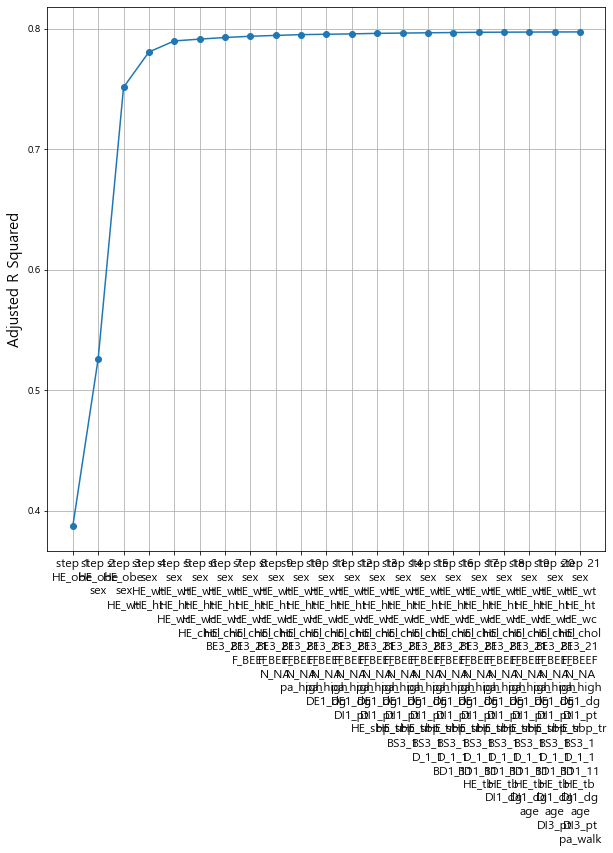

In [72]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [73]:
for i in range(len(sv_per_step)): 
    print(sv_per_step[i], adjusted_r_squared[i])

['HE_obe'] 0.387457152459754
['HE_obe', 'sex'] 0.526292655912054
['HE_obe', 'sex', 'HE_wt'] 0.75144920473691
['sex', 'HE_wt', 'HE_ht'] 0.7807455942492686
['sex', 'HE_wt', 'HE_ht', 'HE_wc'] 0.7899123555252419
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol'] 0.7914312506886323
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21'] 0.792782029141337
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF'] 0.7937879362254857
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF', 'N_NA'] 0.7945014639944108
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF', 'N_NA', 'pa_high'] 0.795159353577736
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF', 'N_NA', 'pa_high', 'DE1_dg'] 0.7954519810644511
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF', 'N_NA', 'pa_high', 'DE1_dg', 'DI1_pt'] 0.7957785517922937
['sex', 'HE_wt', 'HE_ht', 'HE_wc', 'HE_chol', 'BE3_21', 'F_BEEF', 'N_NA', 'pa_high', 'DE1_dg', 'DI1_pt', 'HE_sbp_tr'] 0.79620285655577

In [74]:
# train test split - 종속변수가 총지방량일때 
# using selected variables

feature_columns = df.columns.difference(["총골밀도", "총지방량"]) # Target column 빼기
feature_columns = selected_variables

X_fat = df[feature_columns]
y_fat = df.총지방량

train_x_fat, test_x_fat, train_y_fat, test_y_fat = train_test_split(X_fat,y_fat, train_size = 0.7, test_size = 0.3)

print(train_x_fat.shape, test_x_fat.shape, train_y_fat.shape, test_y_fat.shape)

(8125, 20) (3483, 20) (8125,) (3483,)


In [75]:
# X_col&지방량 OLS

model = sm.OLS(train_y_fat,train_x_fat)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   총지방량   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.799
Method:                 Least Squares   F-statistic:                              1615.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):                        0.00
Time:                        16:12:51   Log-Likelihood:                         -5049.9
No. Observations:                8125   AIC:                                  1.014e+04
Df Residuals:                    8105   BIC:                                  1.028e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.6189      0.009     67.254      0.000       0.601       0.637
HE_wt          0.8374      0.014     61.048      0.000       0.811       0.864
HE_ht         -0.2380      0.010    -23.104      0.000      -0.258      -0.218
HE_wc          0.1916      0.012     16.661      0.000       0.169       0.214
HE_chol        0.0456      0.005      8.686      0.000       0.035       0.056
BE3_21        -0.0295      0.005     -5.591      0.000      -0.040      -0.019
F_BEEF         0.0304      0.005      5.691      0.000       0.020       0.041
N_NA          -0.0271      0.005     -5.280      0.000      -0.037      -0.017
pa_high       -0.0227      0.005     -4.249      0.000      -0.033      -0.012
DE1_dg         0.0196      0.005      3.694      0.000       0.009       0.030
DI1_pt        -0.1139      0.030     -3.771      0.000      -0.173      -0.055
HE_sbp_tr     -0.0207      0.006     -3.354      0.001      -0.033      -0.009
BS3_1          0.0196      0.007      2.779      0.005       0.006       0.033
D_1_1          0.0150      0.005      2.826      0.005       0.005       0.025
BD1_11        -0.0148      0.005     -2.879      0.004      -0.025      -0.005
HE_tb          0.0135      0.005      2.656      0.008       0.004       0.023
DI1_dg         0.0905      0.030      2.995      0.003       0.031       0.150
age           -0.0171      0.008     -2.227      0.026      -0.032      -0.002
DI3_pt        -0.0074      0.005     -1.449      0.147      -0.017       0.003
pa_walk       -0.0098      0.005     -1.915      0.056      -0.020       0.000
==============================================================================
Omnibus:                      115.594   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.271
Skew:                           0.111   Prob(JB):                     1.08e-42
Kurtosis:                       3.722   Cond. No.                         15.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
df['BE3_21'].unique()

array([ 2.32113453,  1.88923325,  1.45733196,  1.02543068,  0.16162812,
       -0.70217445, -0.27027317,  0.5935294 ])

In [77]:
df['BD1_11'].unique()

array([ 1.78022627, -1.34607729,  0.88699668, -0.00623291,  0.44038189,
       -0.4528477 , -0.8994625 ,  2.22684106])

In [78]:
# prediction

pre_y_fat=fitted_model.predict(test_x_fat) 

In [79]:
# MAE

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y_fat, pre_y_fat)

0.3529039615858967

In [80]:
# RMSE

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(test_y_fat, pre_y_fat) 
np.sqrt(MSE)

0.4483766997035172

In [81]:
# r2 score

from sklearn.metrics import r2_score
r2_score(test_y_fat, pre_y_fat)

0.7931527163231075

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


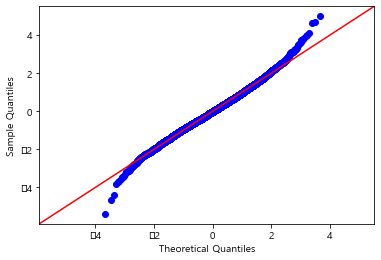

In [82]:
# 학습데이터의 잔차 확인

res = fitted_model.resid

# q-q plot을 통한 잔차의 정규분포 확인
fig = sm.qqplot(res,fit = True,line = '45')

------------------

#### when Y == 총골밀도
#### stepwise selection & OLS

In [83]:
## Stepwise selection - BMI 제거

variables = df.columns[:-2].tolist() ## 설명 변수 리스트
variables.remove('HE_BMI') # BMI 제거하고
 
y = df['총골밀도'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

KeyError: '총골밀도'

In [ ]:
selected_variables

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
# train test split - 종속변수가 총골밀도일때 
# using selected variables

feature_columns = df.columns.difference(["총골밀도", "총지방량"]) # Target column 빼기
feature_columns = ['age',
 'HE_ht',
 'const',
 'HE_wt',
 'sex',
 'BD2_1',
 'BE3_21',
 'HE_wc',
 'HE_HP_tr',
 'HE_chol',
 'HE_HDL_st2',
 'HE_DM',
 'pa_high',
 'D_1_1',
 'HE_crea',
 'HE_alt',
 'L_DN1',
 'F_CHICK',
 'BP1',
 'DI3_dg',
 'BD1_11',
 'pa_mid',
 'N_NA']

X_bone = df[feature_columns]
y_bone = df.총골밀도

train_x_bone, test_x_bone, train_y_bone, test_y_bone = train_test_split(X_bone,y_bone, train_size = 0.7, test_size = 0.3)

print(train_x_bone.shape, test_x_bone.shape, train_y_bone.shape, test_y_bone.shape)

In [ ]:
# X_col&골밀도 OLS

model = sm.OLS(train_y_bone,train_x_bone)
fitted_model = model.fit()

fitted_model.summary()

In [ ]:
# prediction

pre_y_bone=fitted_model.predict(test_x_bone)  

In [ ]:
# MAE

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y_bone, pre_y_bone)

In [ ]:
# r2 score

from sklearn.metrics import r2_score
r2_score(test_y_bone, pre_y_bone)

In [ ]:
# 학습데이터의 잔차 확인

res = fitted_model.resid

# q-q plot을 통한 잔차의 정규분포 확인 - 꼬리를 봐야한다
fig = sm.qqplot(res,fit = True,line = '45')

-----------------------------------------------------

#### when Y == 총골밀도 (머리 제외)
#### stepwise selection & OLS

In [ ]:
## Stepwise selection - BMI 제거

variables = df.columns[:-6].tolist() ## 설명 변수 리스트
variables.remove('HE_BMI') # BMI 제거하고
 
y = df['DW_SBT_BMD'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
# train test split - 종속변수가 총골밀도 (머리제외) 일때 
# using selected variables

feature_columns = df.columns.difference(["총골밀도", "총지방량", "DW_SBT_BMD", "DW_Trk_FT", "DW_Trk_MS", "DW_SBT_FT"]) # Target column 빼기
feature_columns = ['HE_crea',
 'age',
 'HE_wc',
 'HE_ht',
 'sex',
 'HE_wt',
 'const',
 'BD2_1',
 'HE_chol',
 'HE_HDL_st2',
 'D_1_1',
 'HE_HP_tr',
 'HE_DM',
 'BE3_21',
 'pa_high',
 'F_PORK',
 'DI3_dg',
 'BP1',
 'L_DN1',
 'N_NA',
 'pa_mid',
 'HE_alt',
 'HE_ast']

X_bone = df[feature_columns]
y_bone = df.DW_SBT_BMD

train_x_bone, test_x_bone, train_y_bone, test_y_bone = train_test_split(X_bone,y_bone, train_size = 0.7, test_size = 0.3)

print(train_x_bone.shape, test_x_bone.shape, train_y_bone.shape, test_y_bone.shape)

In [ ]:
# X_col&골밀도 (머리제외) OLS

model = sm.OLS(train_y_bone,train_x_bone)
fitted_model = model.fit()

fitted_model.summary()

------------------------------------------------

#### when Y == 대퇴골 T-score
#### stepwise selection & OLS

In [ ]:
## Stepwise selection - BMI 제거

variables = df.columns[:-3].tolist() ## 설명 변수 리스트
# variables.remove('HE_BMI') # BMI 제거하고
 
y = df['대퇴골T-score'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
# train test split - 종속변수가 대퇴골T-score 일때 
# using selected variables

feature_columns = df.columns.difference(['대퇴골T-score', '요추T-score', '대퇴골경부T-score']) # Target column 빼기
feature_columns = ['age',
 'HE_BMI',
 'HE_ht',
 'HE_wc',
 'HW_MS',
 'const',
 'BD2_1',
 'D_1_1',
 'BE3_21',
 'F_PORK',
 'HE_sbp_tr',
 'L_BR1',
 'pa_high',
 'HE_tb',
 'DI3_lt',
 'HE_wt',
 'DI2_dg',
 'L_DN1',
 'N_NA',
 'pa_walk',
 'F_CHICK',
 'HE_glu',
 'HE_chol',
 'HE_HDL_st2']

X_bone = df[feature_columns]
y_bone = df['대퇴골T-score']

train_x_bone, test_x_bone, train_y_bone, test_y_bone = train_test_split(X_bone,y_bone, train_size = 0.7, test_size = 0.3)

print(train_x_bone.shape, test_x_bone.shape, train_y_bone.shape, test_y_bone.shape)

In [ ]:
# X_col&대퇴골T-score OLS

model = sm.OLS(train_y_bone,train_x_bone)
fitted_model = model.fit()

fitted_model.summary()

---------------------------------

#### when Y == 요추T-score
#### stepwise selection & OLS

In [ ]:
## Stepwise selection - BMI 제거

variables = df.columns[:-3].tolist() ## 설명 변수 리스트
# variables.remove('HE_BMI') # BMI 제거하고
 
y = df['요추T-score'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
# train test split - 종속변수가 요추T-score 일때 
# using selected variables

feature_columns = df.columns.difference(['대퇴골T-score', '요추T-score', '대퇴골경부T-score']) # Target column 빼기
feature_columns = ['age',
 'const',
 'HE_wt',
 'HE_wc',
 'BD2_1',
 'HE_chol',
 'HE_alt',
 'HE_DM',
 'D_1_1',
 'HE_dbp_tr',
 'BD1_11',
 'sex',
 'HE_crea',
 'F_PORK',
 'HE_HDL_st2',
 'L_DN1',
 'HE_glu',
 'BP1',
 'HE_tb',
 'DI1_dg']

X_bone = df[feature_columns]
y_bone = df['요추T-score']

train_x_bone, test_x_bone, train_y_bone, test_y_bone = train_test_split(X_bone,y_bone, train_size = 0.7, test_size = 0.3)

print(train_x_bone.shape, test_x_bone.shape, train_y_bone.shape, test_y_bone.shape)

In [ ]:
# X_col&요추T-score OLS

model = sm.OLS(train_y_bone,train_x_bone)
fitted_model = model.fit()

fitted_model.summary()

-----------------------------------------------

#### when Y == 대퇴골경부T-score
#### stepwise selection & OLS

In [ ]:
## Stepwise selection

variables = df.columns[:-3].tolist() ## 설명 변수 리스트
# variables.remove('HE_BMI') # BMI 제거하고
 
y = df['대퇴골경부T-score'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
for i in range(len(sv_per_step)): 
    print(sv_per_step[i])

In [ ]:
# train test split - 종속변수가 대퇴골경부T-score 일때 
# using selected variables

feature_columns = df.columns.difference(['대퇴골T-score', '요추T-score', '대퇴골경부T-score']) # Target column 빼기
feature_columns = ['age',
 'HE_wc',
 'const',
 'D_1_1',
 'BD2_1',
 'sex',
 'pa_high',
 'HE_HP_tr',
 'HE_chol',
 'HE_HDL_st2',
 'HW_MS',
 'F_PORK',
 'HE_BMI',
 'HE_ht',
 'HE_tb',
 'DE1_pt',
 'BE3_21',
 'BP1',
 'L_DN1',
 'L_BR1',
 'N_NA',
 'DI2_dg',
 'HE_alt',
 'HE_crea']

X_bone = df[feature_columns]
y_bone = df['대퇴골경부T-score']

train_x_bone, test_x_bone, train_y_bone, test_y_bone = train_test_split(X_bone,y_bone, train_size = 0.7, test_size = 0.3)

print(train_x_bone.shape, test_x_bone.shape, train_y_bone.shape, test_y_bone.shape)

In [ ]:
# X_col&대퇴골경부T-score OLS

model = sm.OLS(train_y_bone,train_x_bone)
fitted_model = model.fit()

fitted_model.summary()

---------------------------------

In [ ]:
# VIF를 통한 다중공선성 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[feature_columns].values, i) for i in range(df[feature_columns].shape[1])]
vif["features"] = feature_columns
vif

--------------------------------

In [ ]:
# X_col & 골밀도 Poisson Regression

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit(method="lbfgs")

In [ ]:
print(poisson_training_results.summary())

In [ ]:
# predictions

poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

In [ ]:
predictions_summary_frame

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['총골밀도']

In [ ]:
actual_counts

In [ ]:
# MAE

from sklearn.metrics import mean_absolute_error
mean_absolute_error(actual_counts, predicted_counts)

In [ ]:
# MSE

from sklearn.metrics import mean_squared_error 
mean_squared_error(actual_counts, predicted_counts)

In [ ]:
# RMSE

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(actual_counts, predicted_counts) 
np.sqrt(MSE)